# Create Labels

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ee

import rasterio
import numpy as np
from shapely.ops import transform as shp_transform
import pyproj
from rasterio.features import rasterize

from mangroves.geometry import Region
from mangroves.embeddings import Embeddings
from mangroves.collection import Collection
from mangroves.constants import SPATIAL_RESOLUTION_M, REGION_DIAMETER_P



In [2]:
gdf = gpd.read_file("/Users/galex/Desktop/gmw_v3_2020_vec/gmw_v3_2020_vec.shp")

print(gdf.head())         # See first few rows
print(gdf.columns)        # List all attribute columns
print(gdf.crs)            # Coordinate Reference System
print(gdf.shape)          # Number of features (rows) and columns

   PXLVAL                                           geometry
0       1  POLYGON ((172.05689 6.01844, 172.05711 6.01844...
1       1  POLYGON ((172.05689 6.01711, 172.05711 6.01711...
2       1  POLYGON ((172.05511 6.01622, 172.05644 6.01622...
3       1  POLYGON ((172.06178 6.01333, 172.062 6.01333, ...
4       1  POLYGON ((172.06289 6.01333, 172.06311 6.01333...
Index(['PXLVAL', 'geometry'], dtype='object')
EPSG:4326
(1076117, 2)


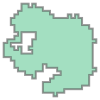

In [3]:
gdf.iloc[-1].geometry

In [4]:
def ratio_pixels_inside(geom, target_crs_epsg=3857, pixel_size=10.0, padding=0.0, all_touched=False):
    """
    Compute ratio of pixels inside a geometry over total pixels in the bounding grid.

    Parameters
    - geom: shapely geometry (in its current CRS, typically EPSG:4326)
    - target_crs_epsg: EPSG code of projected CRS to rasterize in (e.g., 3857 or a UTM zone)
    - pixel_size: pixel size in units of target CRS (meters for most projected CRSs)
    - padding: extra margin added around the geometry bounds (in target CRS units)
    - all_touched: if True, any pixel touched by geometry counts as inside; if False, uses pixel centers

    Returns
    - inside_count: number of pixels flagged inside
    - total_count: total pixels in the grid
    - ratio: inside_count / total_count
    """
    # 1) Reproject geometry to target CRS
    source_crs = "EPSG:4326"  # adjust if your geom is not in lat/lon
    target_crs = f"EPSG:{target_crs_epsg}"
    project = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True).transform
    geom_proj = shp_transform(project, geom)

    # 2) Determine grid bounds in target CRS
    minx, miny, maxx, maxy = geom_proj.bounds
    minx -= padding
    miny -= padding
    maxx += padding
    maxy += padding

    # 3) Compute raster width/height
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))
    if width <= 0 or height <= 0:
        raise ValueError("Computed raster dimensions are non-positive. Check bounds and pixel_size.")

    # 4) Build affine transform (upper-left origin)
    transform = rasterio.transform.from_origin(minx, maxy, pixel_size, pixel_size)
    # Note: from_origin(x_left, y_top, x_res, y_res)

    # 5) Rasterize geometry to a boolean mask
    mask = rasterize(
        [(geom_proj, 1)],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=all_touched,
        dtype=np.uint8
    )

    inside_count = int(mask.sum())
    total_count = int(width * height)
    ratio = inside_count / total_count if total_count > 0 else 0.0
    return inside_count, total_count, ratio, mask

(18, 18) 156 324 0.48148148148148145


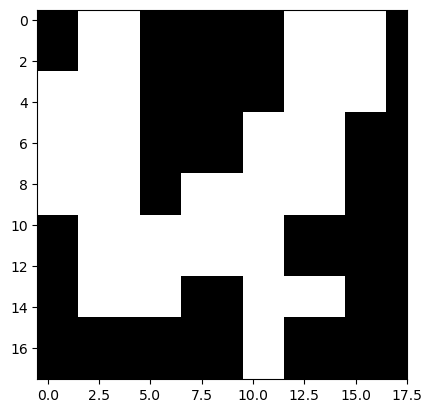

In [5]:
geom = gdf.iloc[-3].geometry
inside_count, total_count, ratio, mask = ratio_pixels_inside(geom)

print(mask.shape, inside_count, total_count, ratio)
plt.imshow(mask, cmap='gray')

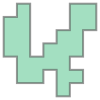

In [6]:
geom

C:\Users\galex\AppData\Local\Temp\ipykernel_6280\671519061.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
C:\Users\galex\AppData\Local\Temp\ipykernel_6280\671519061.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid_lon'] = gdf.centroid.x
C:\Users\galex\AppData\Local\Temp\ipykernel_6280\671519061.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid_lat'] = gdf.centroid.y


                                            geometry  \
0  POLYGON ((172.05689 6.01844, 172.05711 6.01844...   
1  POLYGON ((172.05689 6.01711, 172.05711 6.01711...   
2  POLYGON ((172.05511 6.01622, 172.05644 6.01622...   
3  POLYGON ((172.06178 6.01333, 172.062 6.01333, ...   
4  POLYGON ((172.06289 6.01333, 172.06311 6.01333...   

                    centroid  centroid_lon  centroid_lat  
0    POINT (172.057 6.01833)    172.057000      6.018333  
1   POINT (172.05714 6.0165)    172.057139      6.016500  
2  POINT (172.05578 6.01595)    172.055778      6.015952  
3  POINT (172.06189 6.01322)    172.061889      6.013222  
4    POINT (172.063 6.01322)    172.063000      6.013222  


C:\Users\galex\AppData\Local\Temp\ipykernel_6280\671519061.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf.centroid.iloc[0]


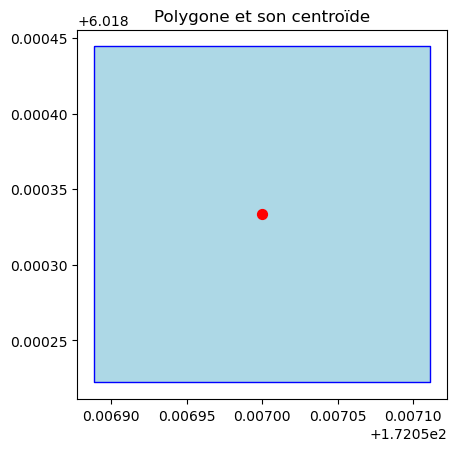

In [7]:
# Calculer le centroïde de chaque géométrie
# Attention : GeoPandas vous avertira peut-être si le CRS est géographique (lat/lon) 
# car le calcul est moins précis qu'en coordonnées projetées, mais cela donne le centre géométrique.
gdf['centroid'] = gdf.geometry.centroid

# Extraire les coordonnées X (Longitude) et Y (Latitude)
gdf['centroid_lon'] = gdf.centroid.x
gdf['centroid_lat'] = gdf.centroid.y

# Afficher les résultats
print(gdf[['geometry', 'centroid', 'centroid_lon', 'centroid_lat']].head())

# Visualiser le premier polygone et son centre
poly = gdf.geometry.iloc[0]
center = gdf.centroid.iloc[0]

# Créer une figure simple pour vérifier
fig, ax = plt.subplots()
gpd.GeoSeries([poly]).plot(ax=ax, color='lightblue', edgecolor='blue')
gpd.GeoSeries([center]).plot(ax=ax, color='red', markersize=50)
plt.title("Polygone et son centroïde")
plt.show()

Ratio de couverture pour le polygone -1: 4.34%


C:\Users\galex\AppData\Local\Temp\ipykernel_6280\2895736564.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


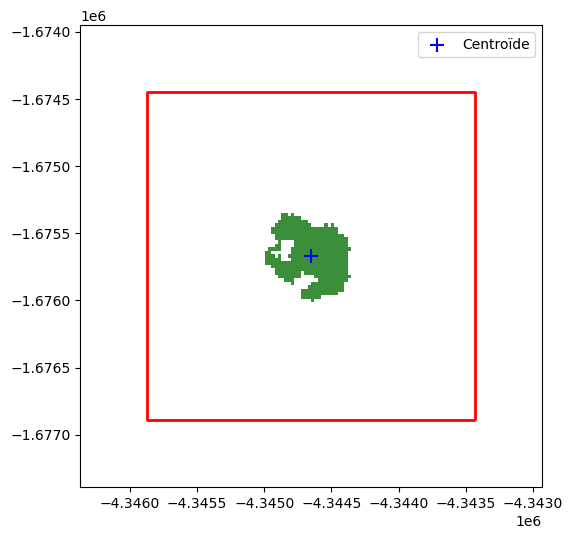

In [8]:
from shapely.geometry import box

def calculate_chip_coverage(poly, centroid, chip_size_px=244, pixel_size=10.0):
    """
    Calcule le taux de couverture (coverage) d'un polygone dans une image (chip) 
    de taille fixe centrée sur un point donné (centroïde).
    """
    # 1. Définir la taille de l'image en mètres
    width_m = chip_size_px * pixel_size
    height_m = chip_size_px * pixel_size
    
    # 2. Créer la bounding box de l'image centrée sur le centroïde
    minx = centroid.x - width_m / 2
    maxx = centroid.x + width_m / 2
    miny = centroid.y - height_m / 2
    maxy = centroid.y + height_m / 2
    chip_geom = box(minx, miny, maxx, maxy)
    
    # 3. Calculer l'intersection entre le polygone mangrove et la chip
    intersection = poly.intersection(chip_geom)
    
    # 4. Ratio = Surface Intersection / Surface Chip
    ratio = intersection.area / chip_geom.area
    return ratio, chip_geom, intersection

# Exemple avec une projection en mètres (EPSG:3857 pour l'exemple)
# Il est crucial d'utiliser un CRS projeté (mètres) et non géographique (degrés)
gdf_proj = gdf.to_crs(epsg=3857)

# Prenons un exemple (le dernier polygone par exemple)
idx = -1
poly = gdf_proj.geometry.iloc[idx]
centroid = poly.centroid

ratio, chip_geom, intersection = calculate_chip_coverage(poly, centroid)

print(f"Ratio de couverture pour le polygone {idx}: {ratio:.2%}")

# Visualisation
fig, ax = plt.subplots(figsize=(6, 6))
gpd.GeoSeries([poly]).plot(ax=ax, color='lightgreen', alpha=0.5, label='Mangrove (Geometry)')
gpd.GeoSeries([chip_geom]).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Image 244x244')
gpd.GeoSeries([intersection]).plot(ax=ax, color='darkgreen', alpha=0.7, label='Intersection (Mangrove dans l\'image)')
gpd.GeoSeries([centroid]).plot(ax=ax, color='blue', marker='+', markersize=100, label='Centroïde')

# Zoomer autour de la chip pour bien voir
minx, miny, maxx, maxy = chip_geom.bounds
margin = 500 # mètres
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

plt.legend()
plt.show()

In [9]:
import sys
import os
import random
import pandas as pd
from tqdm import tqdm

# Ajouter le dossier parent au path pour importer le package mangroves
sys.path.append('..')



# Configuration
OUTPUT_DIR = os.path.join(os.getcwd(), 'output_dataset')
os.makedirs(OUTPUT_DIR, exist_ok=True)
YEAR = 2020  # Année du shapefile
TARGET_SAMPLES_PER_CATEGORY = 5  # Nombre d'images à télécharger par catégorie (ajustez selon vos besoins)

# Charger la clé GEE
try:
    with open('/Users/galex/Desktop/gee_project_key.txt', "r") as f:
        project_key = f.readline().strip()
    collection = Collection(project=project_key)
    print("Collection GEE initialisée.")
except Exception as e:
    print(f"Erreur lors de l'initialisation de la collection GEE : {e}")
    print("Assurez-vous que le fichier de clé existe et est accessible.")

# S'assurer que gdf_proj est défini (projection en mètres)
if 'gdf_proj' not in locals():
    gdf_proj = gdf.to_crs(epsg=3857)
    print("GeoDataFrame projeté en EPSG:3857.")

# Créer l'index spatial s'il n'existe pas déjà (pour accélérer les recherches)
_ = gdf_proj.sindex

2025-12-05 11:36:08,237 - INFO - Google Earth Engine initialized successfully with service account


Collection GEE initialisée.


In [10]:
from rasterio.transform import from_origin
from rasterio.features import rasterize
from shapely.geometry import box

def fetch_and_save_rgb(lat, lon, year, region_diameter_p, spatial_resolution_m, output_path, gdf_proj=None, centroid_proj=None):
    """
    Télécharge et sauvegarde une image RGB Sentinel-2 pour la même zone.
    Si gdf_proj et centroid_proj sont fournis, dessine les contours des mangroves en rouge.
    """
    try:
        # Définir la région
        region = Region(lat, lon, region_diameter_p)
        
        # Collection Sentinel-2 (Surface Reflectance)
        s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(region.region) \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .sort('CLOUDY_PIXEL_PERCENTAGE') \
            .select(['B4', 'B3', 'B2']) # R, G, B
            
        if s2.size().getInfo() == 0:
            print(f"  [RGB] Pas d'image S2 trouvée pour {lat:.4f}, {lon:.4f}")
            return

        image = s2.first()
        
        # Récupérer les pixels
        pixel_data = image.sampleRectangle(region=region.region, defaultValue=0)
        pixel_dict = pixel_data.getInfo()
        
        if 'properties' not in pixel_dict:
            return

        props = pixel_dict['properties']
        if not all(b in props for b in ['B4', 'B3', 'B2']):
            return

        r = np.array(props['B4'])
        g = np.array(props['B3'])
        b = np.array(props['B2'])
        
        # Empiler et Normaliser
        rgb = np.dstack((r, g, b))
        rgb = np.clip(rgb / 3000.0, 0, 1)
        
        # Redimensionnement / Crop
        target_size = int(region_diameter_p)
        h, w, _ = rgb.shape
        
        if h > target_size:
            start_h = (h - target_size) // 2
            rgb = rgb[start_h:start_h+target_size, :, :]
        if w > target_size:
            start_w = (w - target_size) // 2
            rgb = rgb[:, start_w:start_w+target_size, :]
            
        h, w, _ = rgb.shape
        if h < target_size or w < target_size:
            pad_h = max(0, target_size - h)
            pad_w = max(0, target_size - w)
            rgb = np.pad(rgb, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)

        # Flip UD (pour l'image satellite)
        rgb = np.flipud(rgb)
        
        # --- Ajout des contours rouges ---
        if gdf_proj is not None and centroid_proj is not None:
            try:
                # 1. Définir les bornes et la transformation
                width_m = region_diameter_p * spatial_resolution_m
                height_m = region_diameter_p * spatial_resolution_m
                
                minx = centroid_proj.x - width_m / 2
                maxx = centroid_proj.x + width_m / 2
                miny = centroid_proj.y - height_m / 2
                maxy = centroid_proj.y + height_m / 2
                
                # Transformation affine (Origin = Top-Left pour rasterio)
                # Note: rasterio attend (west, north, xsize, ysize)
                transform = from_origin(minx, maxy, spatial_resolution_m, spatial_resolution_m)
                
                # 2. Trouver les géométries intersectantes
                chip_box = box(minx, miny, maxx, maxy)
                possible_matches_index = list(gdf_proj.sindex.intersection(chip_box.bounds))
                possible_matches = gdf_proj.iloc[possible_matches_index]
                precise_matches = possible_matches[possible_matches.intersects(chip_box)]
                
                if not precise_matches.empty:
                    # 3. Rasteriser les contours (boundary)
                    shapes = [(geom.boundary, 1) for geom in precise_matches.geometry]
                    
                    mask = rasterize(
                        shapes,
                        out_shape=(target_size, target_size),
                        transform=transform,
                        fill=0,
                        dtype=np.uint8
                    )
                    
                    # 4. Appliquer le Flip UD au masque pour qu'il corresponde à l'image RGB
                    mask = np.flipud(mask)
                    
                    # 5. Appliquer la couleur rouge (1, 0, 0) là où le masque est actif
                    # On épaissit un peu le trait si besoin, mais rasterize fait déjà 1px (10m)
                    rgb[mask == 1] = [1, 0, 0]
                    
            except Exception as e:
                print(f"  [Overlay] Erreur: {e}")

        # Sauvegarder
        plt.imsave(output_path, rgb)
        
    except Exception as e:
        print(f"  [RGB] Erreur: {e}")

In [ ]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# --- Configuration du Pipeline ---
METADATA_FILE = 'mangrove_metadata.csv'  # Fichier intermédiaire
TARGET_SAMPLES = 10000                   # Objectif par catégorie
MAX_WORKERS = 20                         # Nombre de téléchargements simultanés (Attention aux quotas GEE)

# --- Fonctions Utilitaires ---

def get_category(ratio):
    if ratio == 0: return 0
    elif ratio <= 0.2: return 1
    elif ratio <= 0.4: return 2
    elif ratio <= 0.6: return 3
    elif ratio <= 0.8: return 4
    else: return 5

def calculate_global_coverage(centroid, gdf_proj, chip_size_px=244, pixel_size=10.0):
    # ... (Code identique à précédemment) ...
    width_m = chip_size_px * pixel_size
    height_m = chip_size_px * pixel_size
    minx, maxx = centroid.x - width_m/2, centroid.x + width_m/2
    miny, maxy = centroid.y - height_m/2, centroid.y + height_m/2
    chip_geom = box(minx, miny, maxx, maxy)
    
    possible_matches_index = list(gdf_proj.sindex.intersection(chip_geom.bounds))
    possible_matches = gdf_proj.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(chip_geom)]
    
    if precise_matches.empty:
        return 0.0, chip_geom
        
    intersection_area = precise_matches.intersection(chip_geom).area.sum()
    ratio = min(intersection_area / chip_geom.area, 1.0)
    return ratio, chip_geom

# --- ÉTAPE 1 : Génération du Manifeste (Calculs) ---
# Cette étape ne télécharge rien, elle prépare le terrain.
# Si le fichier existe déjà, on peut le charger directement pour gagner du temps.

if os.path.exists(METADATA_FILE):
    print(f"Chargement des métadonnées existantes depuis {METADATA_FILE}...")
    df_metadata = pd.read_csv(METADATA_FILE)
else:
    print("Génération du manifeste des métadonnées (Calcul des coverages)...")
    metadata_list = []
    
    # On traite tout le dataset (ou une grande partie)
    # Pour la prod, utilisez tout gdf_proj. Pour le test, gardez un subset.
    # gdf_to_process = gdf_proj  <-- DECOMMENTER POUR PROD
    gdf_to_process = gdf_proj.iloc[:2000] # Exemple sur 2000
    
    for idx, row in tqdm(gdf_to_process.iterrows(), total=len(gdf_to_process)):
        centroid = row.geometry.centroid
        ratio, _ = calculate_global_coverage(centroid, gdf_proj)
        cat = get_category(ratio)
        
        # Conversion Lat/Lon
        centroid_geo = gpd.GeoSeries([centroid], crs=gdf_proj.crs).to_crs(epsg=4326).iloc[0]
        
        metadata_list.append({
            'id': idx,
            'ratio': ratio,
            'category': cat,
            'lat': centroid_geo.y,
            'lon': centroid_geo.x,
            'year': YEAR,
            # On ne stocke pas la géométrie complète dans le CSV pour rester léger,
            # on la retrouvera via l'ID si besoin, ou on stocke le WKT si nécessaire.
        })
    
    df_metadata = pd.DataFrame(metadata_list)
    df_metadata.to_csv(METADATA_FILE, index=False)
    print(f"Manifeste sauvegardé : {len(df_metadata)} entrées.")

# Afficher la distribution disponible
print("\nDistribution disponible dans le shapefile :")
print(df_metadata['category'].value_counts().sort_index())

# --- ÉTAPE 2 : Échantillonnage Stratifié ---
print(f"\nSélection de {TARGET_SAMPLES} images par catégorie...")
final_samples_df = pd.DataFrame()

for cat in range(6):
    subset = df_metadata[df_metadata['category'] == cat]
    if len(subset) == 0:
        continue
    
    # Échantillonnage (avec remise si on n'a pas assez ? Non, sans remise c'est mieux pour éviter les doublons)
    n = min(len(subset), TARGET_SAMPLES)
    sampled = subset.sample(n=n, random_state=42)
    final_samples_df = pd.concat([final_samples_df, sampled])

print(f"Total images à télécharger : {len(final_samples_df)}")

# --- ÉTAPE 3 : Téléchargement Parallèle (Worker Pool) ---

# Verrou pour l'écriture thread-safe (si besoin de logs partagés)
print_lock = threading.Lock()

def process_single_sample(row):
    """Fonction exécutée par chaque worker"""
    sample_id = row['id']
    cat = int(row['category'])
    ratio = row['ratio']
    lat = row['lat']
    lon = row['lon']
    year = int(row['year'])
    
    filename_base = f"cat{cat}_id{sample_id}_cov{ratio:.2f}"
    emb_path = os.path.join(OUTPUT_DIR, filename_base + ".npz")
    
    # Skip si déjà fait
    if os.path.exists(emb_path):
        return "Skipped"

    try:
        # 1. Embeddings
        embeddings = Embeddings()
        embeddings.from_collection(lat, lon, year, REGION_DIAMETER_P, SPATIAL_RESOLUTION_M, collection)
        embeddings.save(emb_path, feature_id=sample_id)
        
        # 2. RGB + Contours
        cat_dir = os.path.join(RGB_BASE_DIR, f"cat{cat}")
        os.makedirs(cat_dir, exist_ok=True)
        rgb_path = os.path.join(cat_dir, filename_base + ".png")
        
        # Pour les contours, on a besoin de la géométrie projetée.
        # Comme on est dans un thread, on accède au gdf_proj global (lecture seule = thread safe en Python pour pandas)
        # On récupère le centroïde projeté à la volée ou on le recalcule (rapide)
        # Recalculons le point projeté pour être safe et indépendant
        # (Ou mieux : on passe les coords projetées dans le CSV metadata à l'étape 1)
        # Ici on fait une petite astuce : on utilise le gdf_proj global avec l'ID.
        
        # Attention : gdf_proj.loc[sample_id] est rapide
        feature = gdf_proj.loc[sample_id]
        centroid_proj = feature.geometry.centroid
        
        fetch_and_save_rgb(
            lat, lon, year, 
            REGION_DIAMETER_P, SPATIAL_RESOLUTION_M, 
            rgb_path,
            gdf_proj=gdf_proj,
            centroid_proj=centroid_proj
        )
        return "Success"
        
    except Exception as e:
        return f"Error: {e}"

print(f"\nLancement du téléchargement avec {MAX_WORKERS} workers...")

# Utilisation de ThreadPoolExecutor pour paralléliser les I/O (Réseau)
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Soumettre toutes les tâches
    # On convertit le DataFrame en liste de dictionnaires pour itérer
    futures = {executor.submit(process_single_sample, row): row['id'] for _, row in final_samples_df.iterrows()}
    
    # Barre de progression
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if "Error" in result:
            # On peut logger les erreurs dans un fichier à part
            pass

print("Pipeline terminé !")

Génération du manifeste des métadonnées (Calcul des coverages)...


100%|██████████| 2000/2000 [00:30<00:00, 65.03it/s] 


Manifeste sauvegardé : 2000 entrées.

Distribution disponible dans le shapefile :
category
1    560
2    465
3    556
4    346
5     73
Name: count, dtype: int64

Sélection de 10000 images par catégorie...
Total images à télécharger : 2000

Lancement du téléchargement avec 20 workers...


2025-12-05 11:36:40,579 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,597 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,598 - INFO - Filtered images for 2020: 1
  0%|          | 0/2000 [00:00<?, ?it/s]2025-12-05 11:36:40,624 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,635 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,645 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,655 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,695 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,734 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,736 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,757 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,778 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,850 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,857 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,860 - INFO - Filtered images for 2020: 1
2025-12-05 11:36:40,860 - INFO - Filtered ima

In [ ]:
from numpy import load

dta = load('/Users/galex/Desktop/mangroves/notebooks/output_dataset/cat5_id450_cov0.80.npz')  
dta.files
for item in dta.files:
    print(item)
    print(dta[item])

data
[[[ 0.07535563  0.07111111  0.07972318 ...  0.10340638  0.10851211
    0.11909266]
  [ 0.03844675  0.04158401  0.04484429 ...  0.12456747  0.13016532
    0.11909266]
  [ 0.03543253  0.04158401  0.03844675 ...  0.12456747  0.11909266
    0.11374087]
  ...
  [-0.01384083 -0.0199308  -0.02977316 ...  0.02220684  0.02712803
    0.03844675]
  [-0.02712803 -0.03254133 -0.04158401 ...  0.02712803  0.02977316
    0.04158401]
  [-0.03254133 -0.04484429 -0.05173395 ...  0.03844675  0.03844675
    0.03844675]]

 [[-0.153787   -0.13016532 -0.13016532 ... -0.07111111 -0.07972318
   -0.05536332]
  [-0.22889658 -0.20693579 -0.19986159 ... -0.07111111 -0.07535563
   -0.06299116]
  [-0.24415225 -0.22145329 -0.20693579 ... -0.08421376 -0.07972318
   -0.06299116]
  ...
  [ 0.0199308   0.02977316  0.03844675 ...  0.02977316  0.03254133
    0.06299116]
  [ 0.0120569   0.02220684  0.02977316 ...  0.02977316  0.02977316
    0.06698962]
  [-0.00393695 -0.01574779 -0.00098424 ...  0.03844675  0.04158401
 